In this notebook we show how the user can create custom input functions for btk. These functions could be how the blends are created, how a new detection algorithm could analyze the images etc. It must me noted that for now only parametric bulge+disk galaxies can be drawn by btk. These galaxies are described by parameters in the input CatSim-like catalog.

Here we show custom functions that:
1. Generate blends with galaxies sampled randomly from CatSim catalog, while their position on the postage stamp is randomly drawn from a distribution.
2. Draw blends from a pre-processed wld output with objects being assigned to a "group" if any of their pixels overlap.
3. Generate blend scenes comprised of galaxies within a certain radial distance (in the pixel plane) from a randomly selected CatSim galaxy.
4. Generate blends with different observing conditions (PSF size and exposure time).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import random
import sys
import astropy.table
import numpy as np

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
import btk.config, btk.plot_utils

## 1. Custom sampling function
### Generate blends with galaxies sampled randomly from CatSim catalog, while their position on the postage stamp is randomly drawn from a distrution.

Here we define a new function that: 
- Sample galaxies randomly from the input CatSim catalog.
- Select only galaxies with i band magnitude < 25.3 and r-i > 0.5.
- Number of galaxies in each blend is modelled as a poisson distribution of mean 3.
- x and y coordinates of the galaxies are a determined from normal distribution of 1 arcsec standard deviation.

This new sampling function is input to `btk.create_blend_generator.generate` to create catalogs for each blend scene.


Note: This function uses the One square Degree CatSim catalog as input. For more details on the input catalog refer [here](https://blendingtoolkit.readthedocs.io/en/latest/catalog.html).

In [2]:
def new_center_shift(Args, number_of_objects):
    """Shift galaxy centers with a value drawn from a normal distribution with
    mean 0 and std 1 arcseconds."""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """Returns catalog with parametrs to draw one blend scene.
    
    Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift().
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Determine number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 25.3) & (np.abs(catalog['i_ab'] - catalog['r_ab']) > 0.5))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [3]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'OneDegSq.fits')
# Load parameters
param = btk.config.Simulation_params(catalog_name, max_number=6, batch_size=5)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catalogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_genrator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_genrator)    

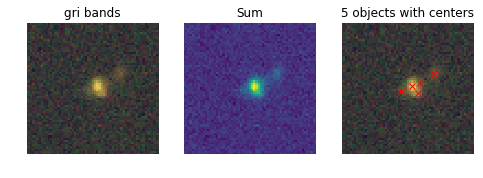

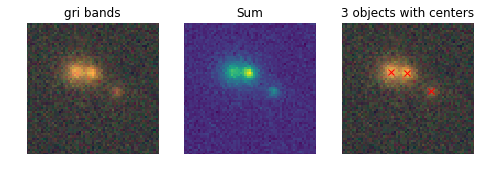

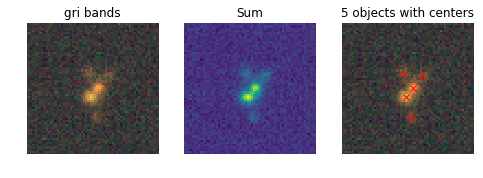

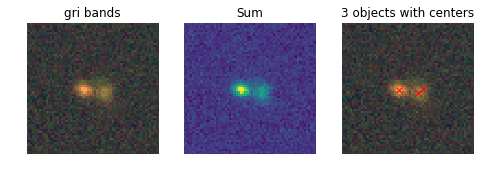

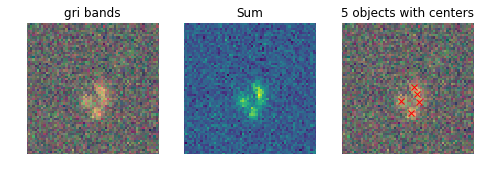

In [4]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

## Draw blends from a pre-processed wld output with objects being assigned to a "group" if any of their pixels overlap.

Here we use real galaxy blend configurations from the input 'OneDegSq.fits' CatSim catalog. The CatSim catalog was processed through the WeakLensingDeblending package (wld) to determine which galaxies are part of the same group. The wld processed catalog consists of galaxy parameters whose profiles were drawn upto a threshold where the pixel value was of 0.1 $\times$ std of noise in the i band. A group consistis of all galaxies that have atleast one overlapping counterpart in the group. See wld [documentation](https://weaklensingdeblending.readthedocs.io/en/latest/index.html) for more details.

In this example we use 'data/sample_group_catalog.fits' a small subsample of the pre-processed wld output catalog with only 10 groups. 
We define a new function, `group_sampling_function`, to sample groups from this catalog and draw them.

We also demonstrate how a selection function can be used to make sure only objects that pass the selection criterion are drawned. Here `new_selection_function` makes sure only galaxies that are brighter than 27 mag in the $i$ band amd smaller than 2 arcsec are drawn.

In [5]:
def group_sampling_function(Args, catalog):
    """Blends are defined from *groups* of galaxies from the CatSim
    catalog previously analyzed with WLD.

    The group is centered on the middle of the postage stamp.
    Function only draws galaxies that lie within the postage stamp size
    determined in Args.

    Note: the pre-run WLD images are not used here. We only use the pre-run
    catalog (in i band) to identify galaxies that belong to a group.
    """
    if not hasattr(Args, 'wld_catalog_name'):
        raise Exception("A pre-run WLD catalog  name should be input as "
                        "Args.wld_catalog_name")
    else:
        wld_catalog = astropy.table.Table.read(Args.wld_catalog_name,
                                               format='fits')
    # randomly sample a group with atleast 2 objects.
    group_ids = np.unique(wld_catalog['grp_id'][wld_catalog['grp_size'] >= 2])
    group_id = np.random.choice(group_ids, replace=False)
    # get all galaxies belonging to the group.
    ids = wld_catalog['db_id'][wld_catalog['grp_id'] == group_id]
    blend_catalog = astropy.table.vstack([catalog[catalog['galtileid'] == i] for i in ids])
    # Set mean x and y coordinates of the group galaxies to the center of the postage stamp. 
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # make sure galaxy centers don't lie too close to edge
    cond1 = np.abs(blend_catalog['ra']) < Args.stamp_size/2. - 3
    cond2 = np.abs(blend_catalog['dec']) < Args.stamp_size/2. - 3
    no_boundary = blend_catalog[cond1 & cond2]
    if len(no_boundary) == 0:
        return no_boundary
    # make sure number of galaxies in blend is less than Args.max_number
    # randomly select max_number of objects if larger.
    num = min([len(no_boundary), Args.max_number])
    select = np.random.choice(range(len(no_boundary)), num, replace=False)
    return no_boundary[select]

def new_selection_function(catalog):
    """Apply selection cuts to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where((a <= 2) & (catalog['i_ab'] <= 27))
    return catalog[q]

In [6]:
# Load catalog reviously run through WLD
wld_catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data/sample_group_catalog.fits')

#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'OneDegSq.fits')
param = btk.config.Simulation_params(catalog_name, max_number=10, batch_size=6)
param.wld_catalog_name = wld_catalog_name
np.random.seed(param.seed)
# Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=new_selection_function)

# Generate catalogs of blended objects. 
# Input group_sampling_function here
blend_generator = btk.create_blend_generator.generate(param, catalog, group_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

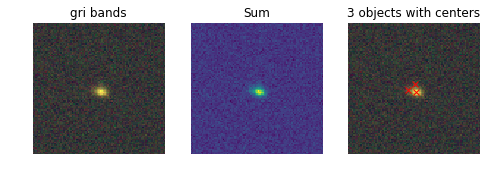

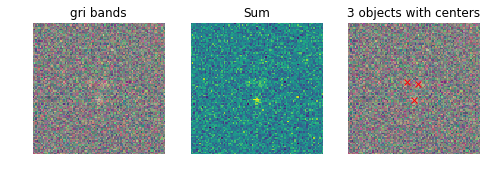

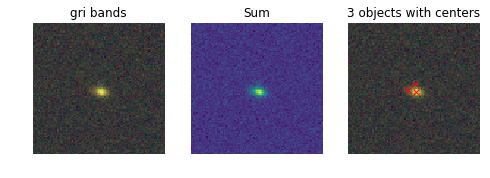

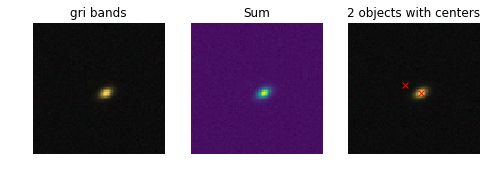

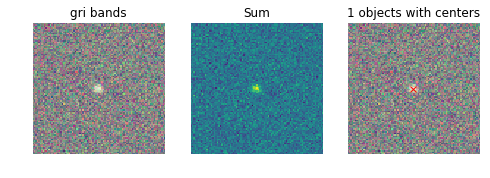

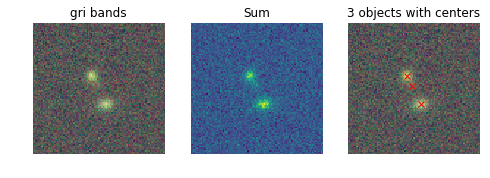

In [7]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(15,105))

## 3. Draw all galaxies within a radius

We define a function `select_within_radius` that picks a galaxy at random and creates a blend scene with it and all objects within a radius of stamp size/5 from its center. 

We also define a new selection function `select_only_gold` that draws only the galaxies in the gold sample (i<25.3)

In [8]:
def select_within_radius(Args, catalog):
    """Returns all galaxies within a radius of stamp_size/5 of a galaxy
    randomly selected from the input catalog.
    
    The function centers the blend to the middle of the postage stamp. It also
    limits the number of objects to max_number
    """
    pick_gal = np.random.choice(len(catalog), 1)
    dx = (catalog['ra'] - catalog['ra'][pick_gal]) * 3600
    dy = (catalog['dec']- catalog['dec'][pick_gal]) * 3600
    dh = np.hypot(dx,dy)  
    q, = np.where(dh < Args.stamp_size/5.)
    blend_catalog = catalog[q]
    # Set mean x and y coordinates of the group galaxies to the center of the postage stamp. 
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # make sure number of galaxies in blend is less than Args.max_number
    # randomly select max_number of objects if larger.
    num = min([len(blend_catalog), Args.max_number])
    select = np.random.choice(range(len(blend_catalog)), num, replace=False)
    return blend_catalog[select]

def select_only_gold(catalog):
    """Apply gold sample selection cut (i<25.3) to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where(catalog['i_ab'] <= 25.3)
    return catalog[q]

In [9]:
param = btk.config.Simulation_params(catalog_name, max_number=10, batch_size=4)

np.random.seed(param.seed)
# Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=select_only_gold)

# Generate catalogs of blended objects. 
# Input group_sampling_function here
blend_generator = btk.create_blend_generator.generate(param, catalog, select_within_radius)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

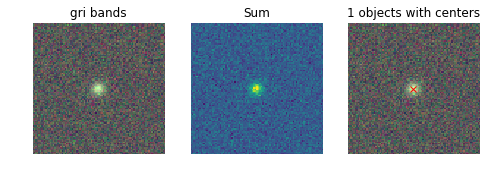

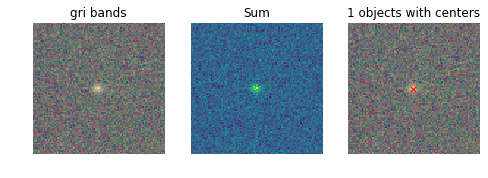

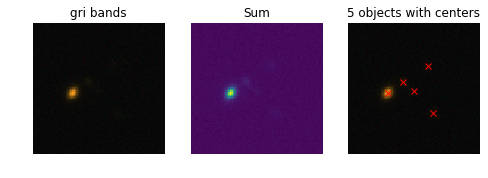

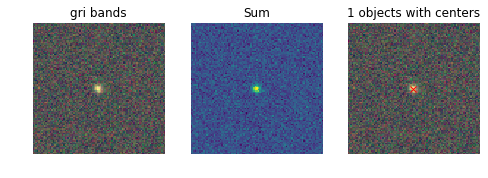

In [10]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(15,105))

## 4.Generate blends with different observing conditions (PSF size and exposure time).

Here we define a function, `custom_obs_condition`, that sets a different observing conditions for each band and blend. Each blend in the batch will have different seeing (atmosphere effects) and PSF (telescope effects) in each band. 
The exposure time is selected from a uniform distribution between 100s and the LSST survey defaults. The PSF fwhm is perturbed slightly from the default FWHM by a value sampled uniformly between -0.1 to 0.1 arcsec.

To more clearly demonstarte this we input a catalog with just 1 galaxy, so that our batch has the same object.

Note: This part uses scarlet.display normalizing function to recscale the displayed rgb images.

In [11]:
import descwl
import scarlet.display

In [12]:
def custom_obs_condition(Args, band):
    """Returns observing conditions from the WLD package
    for a given survey_name and band with a small offset from
    the default parametrs.
    Args
        Args: Class containing parameters to generate blends
        band: filter name to get observing conditions for.
    Returns
        survey: WLD survey class with observing conditions.
    """
    survey = descwl.survey.Survey.get_defaults(
        survey_name=Args.survey_name,
        filter_band=band)
    survey['exposure_time'] = random.uniform(10, survey['exposure_time'])
    survey['zenith_psf_fwhm'] += random.uniform(-0.3,0.3)
    return survey

def same_sample_function(Args, catalog):
    """Returns catalog with parametrs to draw the same galaxy at the
    center of the postage stamp.
    """
    blend_catalog = catalog[catalog['i_ab']<23][0:1]
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    return blend_catalog

def plot_blends_same_scale(blend_images, blend_list, norm ,vmin,
                           vmax, titles=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, and i band image"""
    batch_size = len(blend_list)
    if titles is None:
        titles = ['i band']*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(blend_images[i, :, :, 3],
                  vmin=vmin, vmax=vmax)
        plt.title(titles[i])
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')


In [13]:
param = btk.config.Simulation_params(catalog_name, max_number=1, batch_size=1)
np.random.seed(param.seed)
random.seed(param.seed)
#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)
#Generate catalogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, same_sample_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param, obs_function=custom_obs_condition)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

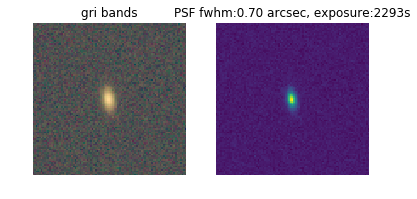

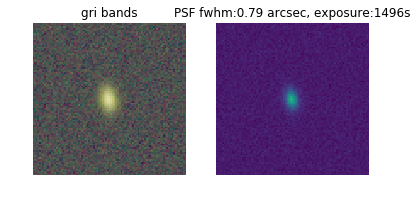

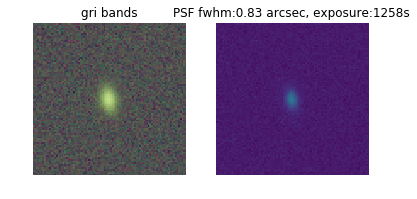

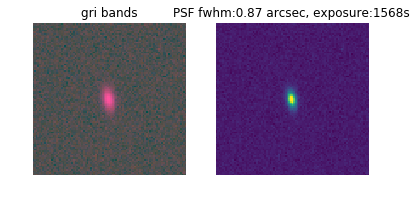

In [14]:
# Same galaxy is drawn with different observing conditions. All image shave same color scale. 

# This cell generates new batch_size number of blends each time it's executed

# Draw blend
rgb_norm = None
i_vmax, i_vmin = None, None
for j in range(4):
    blend_results = next(draw_blend_generator)
    output = blend_results
    blend_images = output['blend_images']
    isolated_images = output['isolated_images']
    blend_list = output['blend_list']
    if rgb_norm is None:
        rgb_norm = scarlet.display.Asinh(img=np.transpose(blend_images[0, :, :, 1:4], axes=(2,0,1)),
                                 Q=20)
        i_vmin, i_vmax = np.min(blend_images[0, :, :, 3]), np.max(blend_images[0, :, :, 3])

    # Plot blended images
    titles = [
        "PSF fwhm:{:.2f} arcsec, exposure:{:.0f}s".format(o[4].zenith_psf_fwhm, o[4].exposure_time) for o in output['obs_condition']]
    plot_blends_same_scale(blend_images, blend_list, rgb_norm, i_vmin, i_vmax, limits=(15,105), titles=titles)